In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 716 kB/s 


In [2]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.6 MB/s 
     |████████████████████████████████| 133 kB 45.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=065e4a96a289ea39a30e853ea374c28983eb0c17a3b82cfb5a87ac1f40add33f
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompa

In [ ]:
!pip3 install pandas_profiling --upgrade

In [ ]:
!pip install -U pandas-profiling

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [4]:
# 데이터 불러오기 
# train data는  (train / val) 로 또 나눠주기
df = pd.read_csv('/content/drive/MyDrive/Section2 Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Section2 Project/test.csv')

In [24]:
# 총 25개의 column
# train size : 103,904
# test size : 25,976
df.shape, test.shape

((103904, 25), (25976, 25))

# 시각화

In [75]:
# 타겟 비율 확인
# 클래스가 균형적인 분류 문제
# 만족X가 56%
target = 'satisfaction'
df[target].value_counts(normalize=True)

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

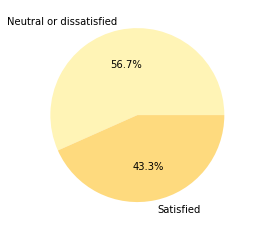

In [42]:
# satisfaction 비율을 pie chart로 확인
plt.pie(df.satisfaction.value_counts(), 
        labels = ["Neutral or dissatisfied", "Satisfied"], 
        colors = sns.color_palette("YlOrBr"), 
        autopct = '%1.1f%%')
pass

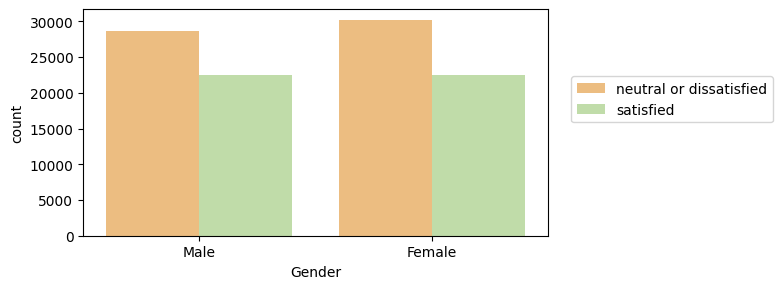

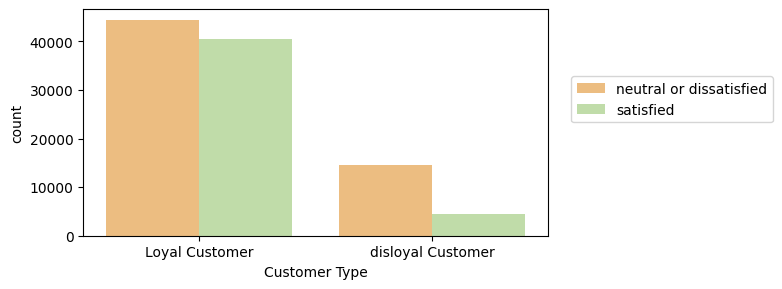

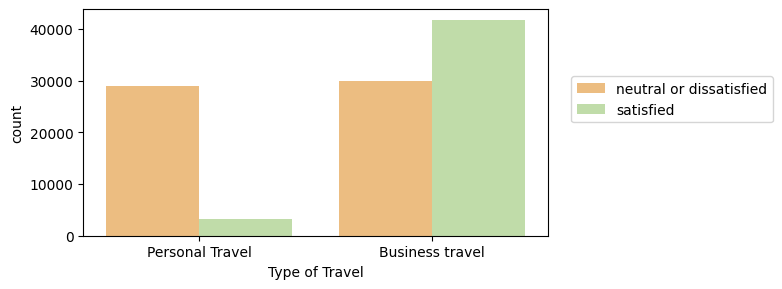

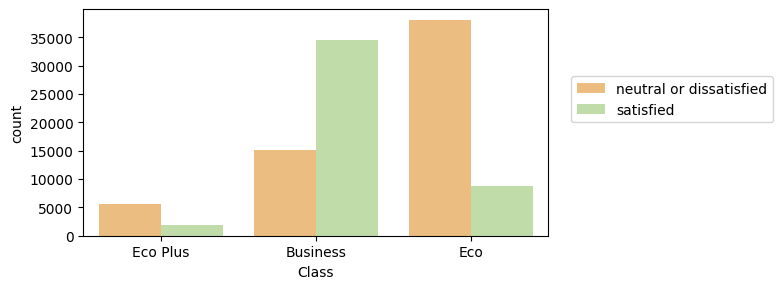

In [36]:
# 카테고리형 feature만 추출
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']

for col in cat_features[:-1]:
    plt.figure(figsize=(6,3), dpi=100)
    sns.countplot(data=df,x=col,hue ='satisfaction', palette='Spectral')
    plt.legend(loc=(1.05,0.5))


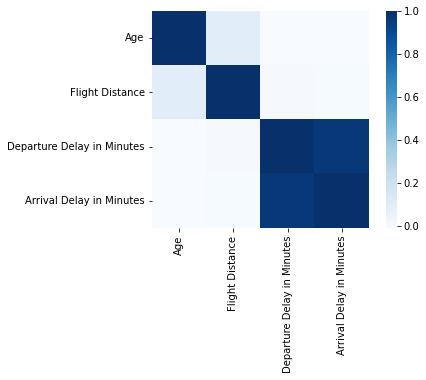

In [54]:
# numeric 끼리 상관관계 확인
numeric_df = df.iloc[:,[4, 7, 22, 23]] # numeric column만 추출
corr_mat = numeric_df.corr()
sns.heatmap(corr_mat, square = True, cmap = 'Blues')
pass

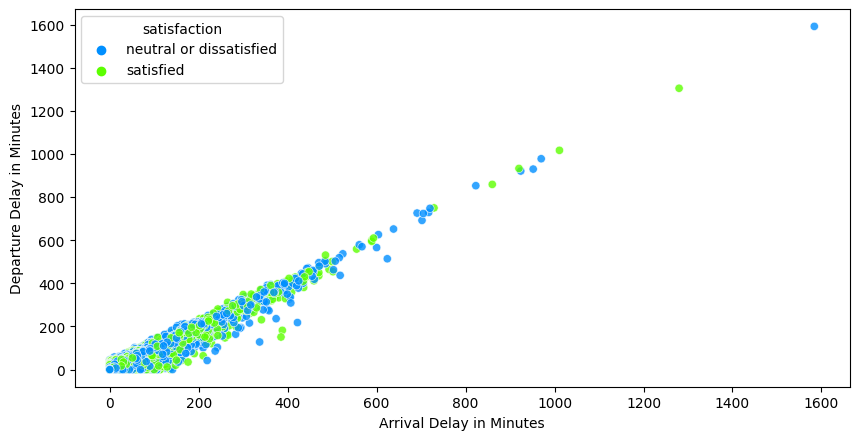

In [60]:
# 지연시간 끼리 선형 관계에 있다는 걸 확인
plt.figure(figsize=(10,5), dpi=100)
sns.scatterplot(data=df,x='Arrival Delay in Minutes',y='Departure Delay in Minutes',hue='satisfaction',palette='gist_rainbow_r', alpha=0.8)

IndexError: ignored

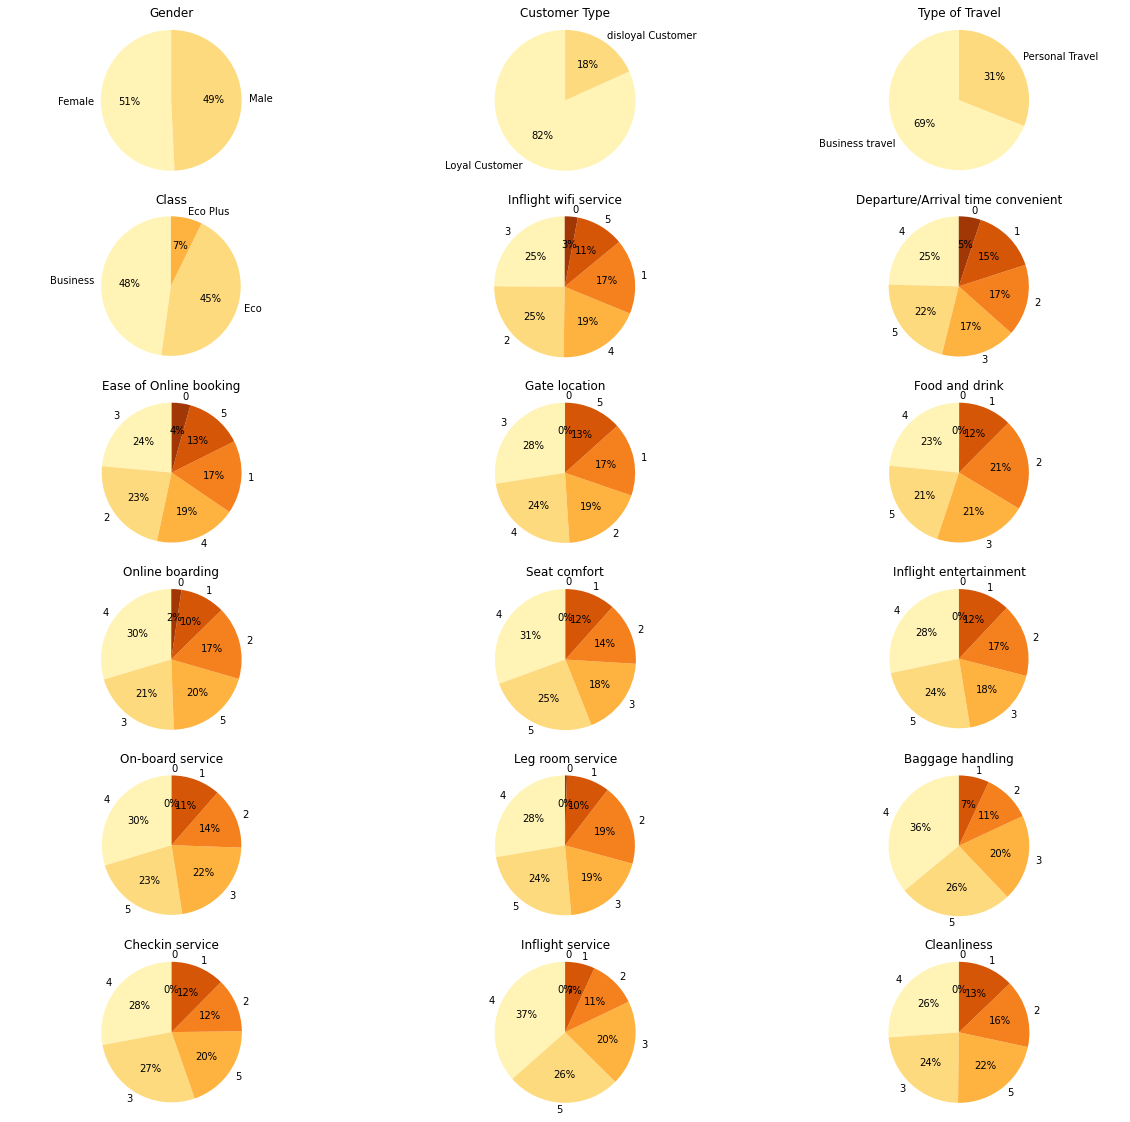

In [59]:
# 카테고리형 특성 비율 확인하기
categ = df.drop(df.iloc[:,[0,1,4, 7, 22, 23]], axis = 1)
fig, axes = plt.subplots(6, 3, figsize = (20, 20))
for i, col in enumerate(categ):
    column_values = df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [76]:
# 너무 높은 카디널리티도 없음
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Gender,103904,2,Female,52727
Customer Type,103904,2,Loyal Customer,84923
Type of Travel,103904,2,Business travel,71655
satisfaction,103904,2,neutral or dissatisfied,58879
Class,103904,3,Business,49665


# EDA

In [44]:
# 쓸모없는 컬럼 삭제 (test도 삭제해줘야 함)
df = df.drop(df.iloc[:,[0, 1]], axis = 1)
test = test.drop(test.iloc[:,[0, 1]], axis = 1)

In [12]:
# 중복행 없음
df.duplicated().sum()

0

In [71]:
# Arrival Delay in Minutes 행에 310개 결측치 있음
df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [45]:
# 결측치를 채워줌
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(axis = 0), inplace = True)

In [74]:
# 결측치 없는 걸 확인
df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [46]:
# satisfaction column 0/1로 바꿔주기
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1

df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
test['satisfaction'] = test['satisfaction'].apply(transform_satisfaction)

# profile_report() 

**error 대처법**

AttributeError: 'DataFrame' object has no attribute 'profile_report'

    !pip install -U pandas-profiling # 이거 실행시키고 런타임 재시작하기

In [ ]:
"""
pr = sample.profile_report()
pr.to_file('./pr_report.html')

sample.profile_report()

"""

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling

In [53]:
# train, val data split

target = "satisfaction"
X = df.drop(columns=target)
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [95]:
# 기준모델 생성 (최빈값 기준)
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

pred_train = dummy_model.predict(X_train)
pred_val = dummy_model.predict(X_val)

accuracy_score(y_train, pred_train), accuracy_score(y_val, pred_val)

(0.5674241786268541, 0.5636398633367018)

In [90]:
# RandomForest

pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True)
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)

print('ROC_AUC: ', roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

ROC_AUC:  0.9590923832232073
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781



In [54]:
# XGBoost

pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=200
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

y_pred = pipe.predict(X_val)

print('ROC_AUC: ', roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

ROC_AUC:  0.9603196756072893
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781



In [7]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('xgb', XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=7, learning_rate=0.2)) 
])

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.9626100765121987


In [8]:
# 특성 중요도 확인

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgb'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=42
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);


feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1635 ± 0.0038,Type of Travel
0.1571 ± 0.0031,Inflight wifi service
0.0727 ± 0.0020,Customer Type
0.0296 ± 0.0017,Online boarding
0.0255 ± 0.0010,Baggage handling
0.0197 ± 0.0022,Inflight service
0.0191 ± 0.0015,Seat comfort
0.0168 ± 0.0012,Checkin service
0.0095 ± 0.0016,Cleanliness
0.0050 ± 0.0005,Age


# test data 적용


In [49]:
target = "satisfaction"
X_test = test.drop(columns=target)
y_test = test[target]

In [55]:
# XGBoost

pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_estimators=200
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

y_pred = pipe.predict(X_test)

print('ROC_AUC: ', roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC_AUC:  0.960452889085572
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.94      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

